In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
from net import NormalNetwork, PCANetwork, train_network, test_network
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Train with MNIST dataset

In [2]:
model = NormalNetwork(unpack_data=True)

In [3]:
train_network(model)

Training epoch 20: 100%|██████████| 1875/1875 [00:01<00:00, 1124.72it/s]


#### Test with MNIST dataset

In [4]:
res = test_network(model)
print(res)

Testing network: 100%|██████████| 313/313 [00:00<00:00, 2659.84it/s]

{'accuracy': 0.9799, 'loss': 0.0655388625852942, 'confusion matrix': array([[ 971,    0,    0,    0,    1,    3,    0,    1,    3,    1],
       [   0, 1128,    3,    0,    0,    1,    2,    0,    1,    0],
       [   4,    1, 1013,    2,    2,    0,    1,    3,    6,    0],
       [   0,    0,    6,  989,    0,    4,    0,    2,    4,    5],
       [   0,    0,    5,    0,  967,    0,    2,    0,    0,    8],
       [   3,    1,    0,    8,    1,  872,    3,    1,    1,    2],
       [   4,    3,    2,    1,    5,    8,  935,    0,    0,    0],
       [   2,    6,    9,    2,    4,    0,    0,  990,    2,   13],
       [   3,    0,    4,    3,    4,    5,    3,    2,  947,    3],
       [   3,    2,    0,    2,   10,    4,    0,    1,    0,  987]])}


#### Plot confusion matrix

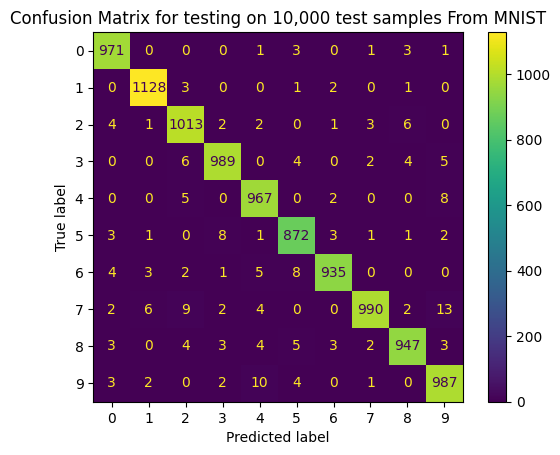

In [5]:
disp = ConfusionMatrixDisplay(confusion_matrix= res["confusion matrix"])
disp.plot()
plt.title("Confusion Matrix for testing on 10,000 test samples From MNIST")
plt.show()

#### Train with PCA data

In [6]:
model = PCANetwork(0.75, unpack_data=True)

In [7]:
model

PCANetwork(
  (forward_prob): Sequential(
    (0): Linear(in_features=120, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
  (loss_func): CrossEntropyLoss()
)

In [8]:
train_network(model)

Training epoch 20: 100%|██████████| 1875/1875 [00:00<00:00, 5116.35it/s]


In [9]:
res = test_network(model)
print(res)

Testing network: 100%|██████████| 313/313 [00:00<00:00, 5504.36it/s]

{'accuracy': 0.9694, 'loss': 0.10818500133858362, 'confusion matrix': array([[ 967,    0,    1,    2,    2,    2,    3,    2,    1,    0],
       [   0, 1125,    3,    1,    0,    0,    3,    0,    3,    0],
       [   8,    2,  990,    8,    2,    1,    5,    8,    7,    1],
       [   0,    0,    5,  977,    1,   10,    0,    7,    4,    6],
       [   0,    0,    6,    0,  958,    0,    8,    2,    2,    6],
       [   4,    1,    1,   10,    2,  862,    5,    1,    4,    2],
       [   7,    3,    2,    0,    5,   19,  919,    0,    3,    0],
       [   1,   10,   11,    1,    3,    0,    0,  992,    2,    8],
       [   3,    1,    4,    8,    4,    6,    3,    4,  936,    5],
       [   3,    5,    0,    6,   14,    5,    0,    7,    1,  968]])}


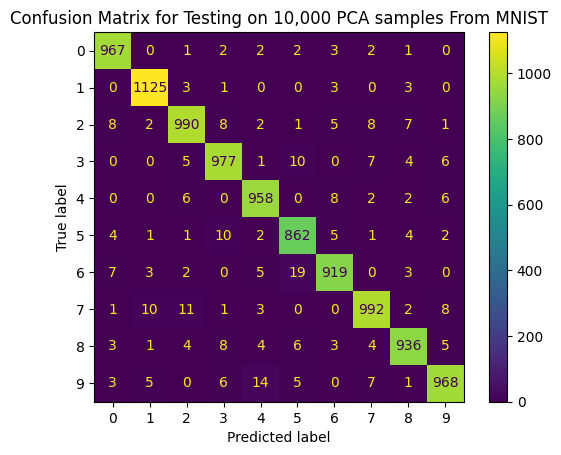

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=res["confusion matrix"])
disp.plot()
plt.title("Confusion Matrix for Testing on 10,000 PCA samples From MNIST")
plt.show()

In [11]:
from graph import draw_metric_graph, draw_time_graph

Initializing networks...


Testing network: 100%|██████████| 313/313 [00:00<00:00, 2872.99it/s]


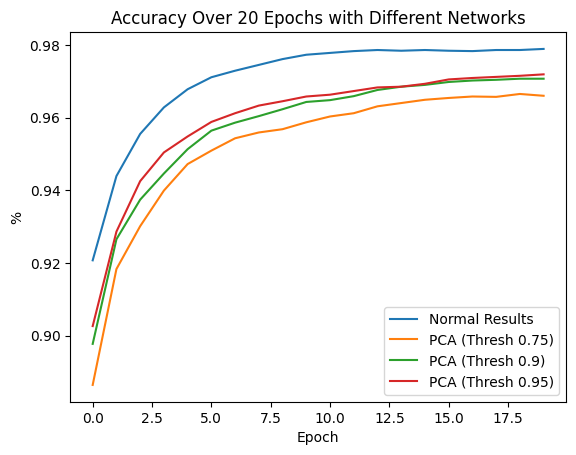

In [12]:
draw_metric_graph(pca_thresh=[0.75, 0.90, 0.95], epochs=20)

Training epoch 10: 100%|██████████| 1875/1875 [00:00<00:00, 5124.95it/s]


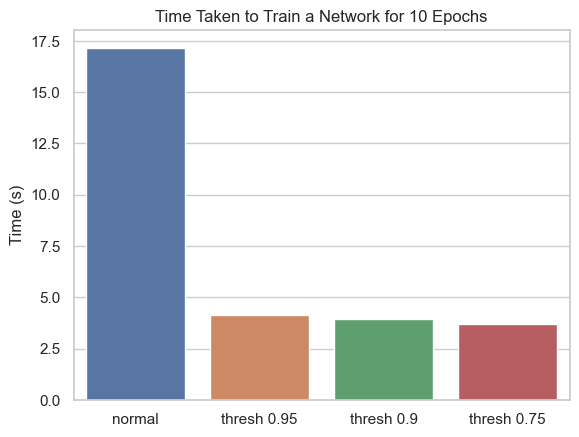

In [13]:
draw_time_graph(pca_thresh=[0.95, 0.90, 0.75], epochs=10)